In [217]:
from math import atan2, degrees
import matplotlib.pyplot as plt

class Point:
    def __init__(self, x: float, y: float):
        self.x = x
        self.y = y

    def __repr__(self) -> str:
        return f"({self.x}, {self.y})"

    def __str__(self) -> str:
        return f"({self.x}, {self.y})"

    def __eq__(self, __o: object) -> bool:
        return (self.x == __o.x and self.y==__o.y)
  
    def __add__(self, __o):
        return Point((self.x+__o.x), (self.y+__o.y))
    
    def __truediv__(self, __o: int):
        return Point(self.x/__o, self.y/__o)
    
    def __hash__(self) -> int:
        return hash(self.__repr__())

class Polygon:
    def __init__(self, *vertices): 
        # if (len(vertices) < 3):
        #     raise ValueError("Polygon of less than 3 sides is not possible")
            
        self.V = set()
        temp = []
        for pt in vertices:
            if isinstance(pt, Point):
                self.V.add(pt)
                temp.append(pt)
            else:
                self.V.add(Point(pt[0], pt[1]))
                temp.append(Point(pt[0], pt[1]))
        
        self.n = len(self.V)

        self.E = []
        for i in range(self.n):
            self.E.append((temp[i], temp[(i+1)%self.n]))
    
    def get_ccw_vertices(self):
        return [e[0] for e in self.E]

    def __repr__(self) -> str:
        return f"Polygon({self.V})"

    def __str__(self) -> str:
        return f"{self.V}"
    
    def __eq__(self, __o: object) -> bool:
        return self.V == __o.V

    def __hash__(self):
        return hash(self.__repr__())
    
def is_inside(A: Point, P: Polygon) -> bool:
    '''Checks is point A is inside a triangle P'''

    if P.n > 3: raise(ValueError("Funtion only works for triangles"))

    # print(P)

    [a,b,c] =[e[0] for e in P.E]
    ax_ = a.x-A.x
    ay_ = a.y-A.y
    bx_ = b.x-A.x
    by_ = b.y-A.y
    cx_ = c.x-A.x
    cy_ = c.y-A.y
    return ((
        (ax_*ax_ + ay_*ay_) * (bx_*cy_-cx_*by_) -
        (bx_*bx_ + by_*by_) * (ax_*cy_-cx_*ay_) +
        (cx_*cx_ + cy_*cy_) * (ax_*by_-bx_*ay_)
    ) >= 0)

def triangle_overlap(A: Polygon, B: Polygon):
    '''Checks if triangle A overlaps with triangle B'''
    if A.n > 3 or B.n > 3: raise(ValueError("Funtion only works for triangles"))
    
    flag = False
    for v_a in A.V:
        flag = flag or is_inside(v_a, B) 
    
    return flag
         

def get_ccw(pts: list[Point]):
    '''Sorts list of points in counter-clockwise order'''
    cent = sum(pts, Point(0,0))/len(pts)
    pts.sort(key = lambda a: (degrees(atan2(a.x - cent.x, a.y - cent.y)) + 360 % 360), reverse=True)
    return pts

                    

def plot_poly(P: Polygon, ocol = "k-"):
    for (p1,p2) in P.E:
        plt.plot([p1.x, p2.x], [p1.y, p2.y], ocol)

def plot_polys(T):
    for poly in T:
        plot_poly(poly)

P1 = Polygon((20, 0),(20, 15),(-20, 10),(-20, -20))
P2 = Polygon((-75, -25),(-50, -25),(-50, 0),(-60, -15),(-75, 0))

In [227]:
class Hierarchy:
    def __init__(self) -> None:
        self.adj = dict()
        self.nodes = set()
        self.polys = list()
        self.poly_map = dict()
        self.regions = dict()
        self.triangulation = set()
        self.enclosing_triangle = Polygon((100, 0),(-100, 100),(-100, -100))
    
    def add_region(self, poly: Polygon, name: str):
        self.regions[poly] = name
        self.polys.append(poly)
    
    def add_node(self, poly: Polygon):
        self.nodes.add(poly)
        self.adj[poly] = []

    def triangulate_helper(self, polys: list[Polygon], outer: bool = True):
        '''Bowyer-Watson Algorithm for triangulation'''
        super_t = self.enclosing_triangle
        triangulations = set([super_t])

        for poly in polys:
            vertices = poly.V
            for vertex in vertices:    
                bad_triangles = []
                for tpoly in triangulations:
                    if (is_inside(vertex, tpoly)):
                        bad_triangles.append(tpoly)

                p_set = []

                for bpoly in bad_triangles:
                    for edge in bpoly.E:
                        flag = True
                        for _bpoly in bad_triangles:
                            if _bpoly == bpoly: continue
                            for _edge in _bpoly.E:
                                if edge == _edge or (edge[1],edge[0]) == _edge:
                                    flag = False

                        if flag:
                            p_set.append(edge)

                for bpoly in bad_triangles:
                    triangulations.remove(bpoly)
                
                for edge in p_set:
                    [x, y, z] = get_ccw([edge[0], edge[1], vertex])
                    triangulations.add(Polygon(x, y, z))

        if not outer:
            to_be_removed = []
            for tri in triangulations:
                vertices = tri.get_ccw_vertices()
                for vertex in vertices:
                    if vertex in super_t.V:
                        to_be_removed.append(tri)
                        break
            
            for tri in to_be_removed:
                triangulations.remove(tri)
        
        return triangulations

    def triangulate(self):
        
        triangulations = self.triangulate_helper(self.polys)

        for poly in self.polys:
            for tri in triangulations:
                vertices = tri.get_ccw_vertices()
                flag = True
                for vertex in vertices:
                    if vertex not in poly.V: 
                        flag = False
                        break
                if flag: self.poly_map[tri] = poly
            
        for tri in triangulations:
            self.nodes.add(tri)
            self.adj[tri] = []
        
        self.triangulation = triangulations
    
    def remove_point(self, p: Point):
        removed_triangles = set()
        for tri in self.triangulation:
            if p in tri.V: removed_triangles.add(tri)

        v_set = set()
        for tri in removed_triangles:
            for v in tri.V:
                v_set.add(v)
            self.triangulation.remove(tri)


        v_set.remove(p)
        for vertex in self.enclosing_triangle.V: 
            if vertex in v_set: v_set.remove(vertex)
        
        print(self.enclosing_triangle.V)
        v_list = get_ccw(list(v_set))
        
        # Retriangulating
        new_triangles = self.triangulate_helper([Polygon(*v_list),], outer= False)
        for tri in new_triangles: 
            self.triangulation.add(tri)
            self.add_node(tri)

        for new in new_triangles:
            for old in removed_triangles:
                if triangle_overlap(new, old):
                    self.adj[new].append(old)

    def select_independent_set(self):
        v_set = set()
        independent_set = set()
        off_limits = set([i for i in self.enclosing_triangle.V])

        for tri in self.triangulation:
            for vertex in tri.V: v_set.add(vertex)
        
        for vertex in v_set:
            if vertex in off_limits:
                continue
            independent_set.add(vertex)
            off_limits.add(vertex)
            for tri in self.triangulation:
                if vertex in tri.V:
                    map(lambda item: off_limits.add(item), tri.V)
        
        return independent_set


In [228]:
def Algorithm(regions: list[Polygon], region_names: list[str]):
    H = Hierarchy()

    for region, name in zip(regions, region_names):
        H.add_region(region, name)
    
    H.triangulate()

    while (len(H.triangulation) > 1):
        independent_set = H.select_independent_set()

        print(independent_set)
        # input()

        for vertex in independent_set:
            print(H.triangulation)
            print(f"removing {vertex}")
            if (len(H.triangulation) <= 1): break
            H.remove_point(vertex)
        print(H.triangulation)
        
    

{(-20, -20), (-20, 10), (20, 0)}
{Polygon({(100, 0), (-100, 100), (20, 0)}), Polygon({(-20, 10), (-20, -20), (20, 0)}), Polygon({(-20, -20), (-100, -100), (100, 0)}), Polygon({(-20, -20), (100, 0), (20, 0)}), Polygon({(-20, 10), (-100, 100), (20, 0)}), Polygon({(-20, 10), (-100, -100), (-100, 100)}), Polygon({(-20, -20), (-100, -100), (-20, 10)})}
removing (-20, -20)
{(-100, -100), (100, 0), (-100, 100)}
{Polygon({(100, 0), (-100, 100), (20, 0)}), Polygon({(-20, 10), (-100, 100), (20, 0)}), Polygon({(-20, 10), (-100, -100), (-100, 100)})}
removing (-20, 10)
{(-100, -100), (100, 0), (-100, 100)}
{Polygon({(100, 0), (-100, 100), (20, 0)})}
removing (20, 0)
{Polygon({(100, 0), (-100, 100), (20, 0)})}


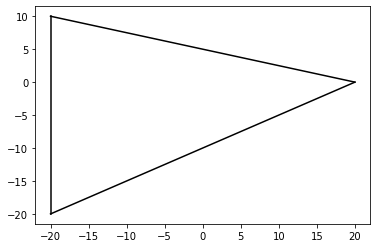

In [232]:
P1 = Polygon((20, 0),(-20, 10),(-20, -20))
P2 = Polygon((-75, -25),(-50, -25),(-50, 0),(-60, -15),(-75, 0))

plot_poly(P1)

regions = [P1,]
region_names = ["R1",]

Algorithm(regions, region_names)

In [ ]:
print(H.tri)

# Garbage

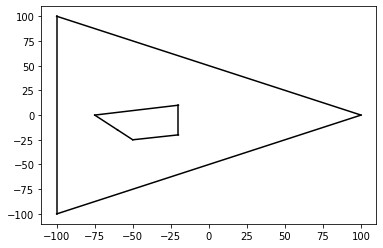

In [179]:
PP = Polygon((-50, -25), (-20, -20), (-20, 10), (-75, 0), (-60, -15))
super_t = Polygon((100, 0),(-100, 100),(-100, -100))

plot_polys([PP, super_t])


In [136]:


def triangulate(figure: list[Polygon]):
    super_t = Polygon((100, 0),(-100, 100),(-100, -100))
    triangulations = set([super_t])

    for poly in figure:
        vertices = poly.V
        for vertex in vertices:    
            bad_triangles = []
            for tpoly in triangulations:
                if (is_inside(vertex, tpoly)):
                    bad_triangles.append(tpoly)

            p_set = []

            for bpoly in bad_triangles:
                for edge in bpoly.E:
                    flag = True
                    for _bpoly in bad_triangles:
                        if _bpoly == bpoly: continue
                        for _edge in _bpoly.E:
                            if edge == _edge or (edge[1],edge[0]) == _edge:
                                flag = False

                    if flag:
                        p_set.append(edge)

            for bpoly in bad_triangles:
                triangulations.remove(bpoly)
            
            for edge in p_set:
                [x, y, z] = get_ccw([edge[0], edge[1], vertex])
                triangulations.add(Polygon(x, y, z))
        
    return triangulations

    

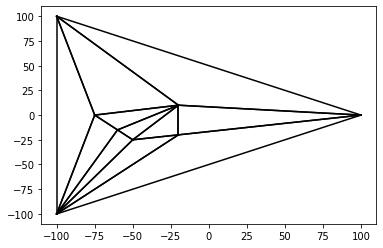

In [180]:
P1 = Polygon((20, 0),(20, 15),(-20, 10))

plot_polys(triangulate([PP,]))


In [ ]:
vrem = Point(-50, 0)

T = triangulate([P1, P2])

plot_polys(T)

plot_poly(P1, 'r-')
plot_poly(P2, 'b-')

In [ ]:
def get_ccw(pts: list[Point]):
    cent = sum(pts, Point(0,0))/len(pts)
    pts.sort(key = lambda a: (degrees(atan2(a.x - cent.x, a.y - cent.y)) + 360 % 360), reverse=True)
    return pts

tbr = []
for t in T:
    if vrem in t.V: tbr.append(t)

v_set = set()
for t in tbr:
    for v in t.V:
        v_set.add(v)
    T.remove(t)

v_set.remove(vrem)

vl = list(v_set)
print(v_set)

vl = get_ccw(vl)
print(vl)